In [1]:
#import
#python 3.7 version
#tensorflow 2.3 version
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

#InceptionV3
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor

#tensorflow image processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

#make callback to get valiable metrics
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import (f1_score, precision_score, recall_score)


#from collections import Counter
import itertools
import numpy as np 
import pandas as pd

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

#make train set, validation set by split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

#make date to save models as filename
from datetime import datetime

#make chart to visulaize
import matplotlib.pyplot as plt

#ignore error code, it`s not recommend at editing
import warnings
warnings.filterwarnings('ignore')

import os

In [2]:
tf.config.run_functions_eagerly(True)

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9104039205248527890
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13457856494430428266
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3050779444
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16198405716256729699
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 159363273668862055
physical_device_desc: "device: XLA_GPU device"
]


In [4]:
dir_name = "Learning_log"

def make_Tensorboard_dir(dir_name):
    root_logdir = os.path.join(os.curdir, dir_name)
    sub_dir_name = datetime.today().strftime("%Y%m%d-%H%M%S")
    return os.path.join(root_logdir, sub_dir_name)

TB_log_dir = make_Tensorboard_dir(dir_name)
TensorB = tf.keras.callbacks.TensorBoard(log_dir = TB_log_dir)

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
train_folder = 'C:/Users/BVer/dog_/YJ_Kim/dataset/img_mixed/'
train_dogs = pd.read_csv('C:/Users/BVer/dog_/YJ_Kim/dataset/filelist.csv')
train_dogs.head()

,fileName,name,label,Extension,Folder_Path,folder
0,affenpinscher1.jpg,affenpinscher1,affenpinscher,.jpg,C:/Users/BVer/dog_/YJ_Kim/dataset/img_mixed/,/img_mixed/
1,affenpinscher10.jpg,affenpinscher10,affenpinscher,.jpg,C:/Users/BVer/dog_/YJ_Kim/dataset/img_mixed/,/img_mixed/
2,affenpinscher100.jpg,affenpinscher100,affenpinscher,.jpg,C:/Users/BVer/dog_/YJ_Kim/dataset/img_mixed/,/img_mixed/
3,affenpinscher101.jpg,affenpinscher101,affenpinscher,.jpg,C:/Users/BVer/dog_/YJ_Kim/dataset/img_mixed/,/img_mixed/
4,affenpinscher102.jpg,affenpinscher102,affenpinscher,.jpg,C:/Users/BVer/dog_/YJ_Kim/dataset/img_mixed/,/img_mixed/


In [7]:
target_labels = train_dogs['label']

In [8]:
train_data = np.array([img_to_array(load_img(img, target_size=(200, 200))) for img in (train_folder + train_dogs['fileName'].values).tolist()]).astype('float32')

In [9]:
# One hot code the labels - need this for the model
one_hot = pd.get_dummies(target_labels, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [10]:
x_train, x_validation, y_train, y_validation = train_test_split(train_data, one_hot_labels, test_size=0.2, stratify=np.array(target_labels), random_state=100)

In [11]:
print ('x_train shape = ', x_train.shape)
print ('x_validation shape = ', x_validation.shape)
print ('y_train shape = ', y_train.shape)
print ('y_validation shape = ', y_validation.shape)

x_train shape =  (25889, 200, 200, 3)
x_validation shape =  (6473, 200, 200, 3)
y_train shape =  (25889, 120)
y_validation shape =  (6473, 120)


In [13]:
base_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape=(200, 200, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
predictions = Dense(120, activation='softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)

for layer in base_model.layers:
    layer.trainable = False

#model.compile(Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

87916544/87910968 [==============================] - 5s 0us/step


In [14]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   zoom_range = 0.2, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(x_train, y_train, shuffle=False, batch_size=16)
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(x_validation, y_validation, shuffle=False, batch_size=16)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

epochs = 20
history = model.fit_generator(
    generator = train_generator,
    steps_per_epoch = len(train_generator),
    validation_data = val_generator,
    validation_steps = len(val_generator),
    epochs = epochs,
    callbacks=[
        ModelCheckpoint('models/' + 'InceptionV3.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto'),
        TensorB
    ]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
   1/1619 [..............................] - ETA: 0s - loss: 5.7193 - accuracy: 0.0000e+00WARNING:tensorflow:From C:\Users\BVer\miniconda3\envs\sch\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1619/1619 [==============================] - 396s 244ms/step - loss: 2.0645 - accuracy: 0.4940 - val_loss: 1.6032 - val_accuracy: 0.5730
Epoch 2/20
1619/1619 [==============================] - 360s 222ms/step - loss: 1.5208 - accuracy: 0.5916 - val_loss: 1.5633 - val_accuracy: 0.5769
Epoch 3/20
1619/1619 [==============================] - 338s 209ms/step - loss: 1.4296 - accuracy: 0.6075 - val_loss: 1.5066 - val_accuracy: 0.5895
Epoch 4/20
1619/1619 [==============================] - 323s 200ms/step - loss: 1.3733 - accuracy: 

In [20]:
trial = "InseptionV3_1"
model.save_weights(datetime.today().strftime("%Y%m%d")+ '_weights_' +str(epochs) + '_' + str(trial) +'.h5')
model.save(datetime.today().strftime("%Y%m%d")+ '_model_'+ str(epochs) + '_' + str(trial) +'.h5')

Text(0.5, 0, 'Epoch')

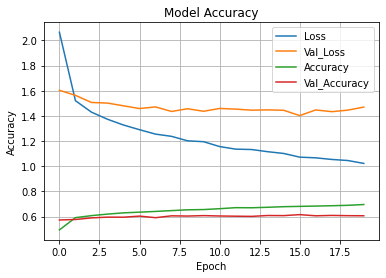

In [21]:
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Val_Loss')
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val_Accuracy')
plt.legend()
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

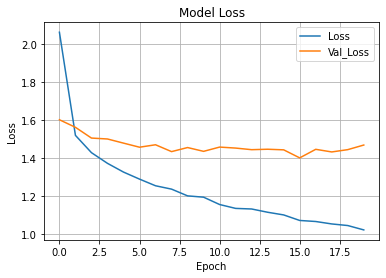

In [22]:
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Val_Loss')
plt.title('Model Loss')
plt.legend()
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

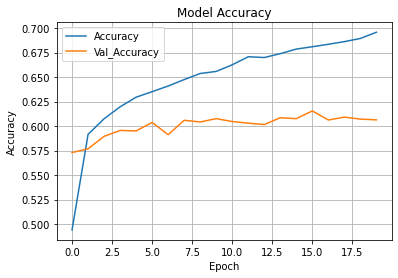

In [23]:
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val_Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [24]:
scores = model.evaluate_generator(val_generator, steps=5)

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [25]:
print("-- Evaluate --")
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
accuracy: 60.00%


In [ ]:
base_model.trainable = True
#model.summary()

model.compile(Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 5
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)

trial = 'InseptionV3_finetuning_1'
# model.save_weights(datetime.today().strftime("%Y%m%d")+ '_weights_ft_' +str(epochs) + '_' + str(trial) +'.h5')
model.save(datetime.today().strftime("%Y%m%d")+ '_model_ft_'+ str(epochs) + '_' + str(trial) +'.h5')

Epoch 1/5
1619/1619 [==============================] - 355s 219ms/step - loss: 1.7392 - accuracy: 0.5429 - val_loss: 1.2784 - val_accuracy: 0.6368
Epoch 2/5
1619/1619 [==============================] - 371s 229ms/step - loss: 1.2550 - accuracy: 0.6404 - val_loss: 1.1660 - val_accuracy: 0.6683
Epoch 3/5
1619/1619 [==============================] - 389s 240ms/step - loss: 1.1048 - accuracy: 0.6745 - val_loss: 1.1035 - val_accuracy: 0.6818
Epoch 4/5
1619/1619 [==============================] - 369s 228ms/step - loss: 0.9831 - accuracy: 0.7070 - val_loss: 1.0693 - val_accuracy: 0.6992
Epoch 5/5
1619/1619 [==============================] - 359s 221ms/step - loss: 0.9062 - accuracy: 0.7269 - val_loss: 1.0801 - val_accuracy: 0.6970 - loss: 0.9071 - accuracy: 0.726 - ETA: 24s - loss: 0.9071 - ac - ETA: 22 - ETA: 15s - loss: 0.9051 - accur - ETA: 13s - loss: 0.9052 - - E - ETA: 2s - loss: 0.9059 - accuracy: 0.72 - ETA: 1s - loss: 0.9


NameError: name 'InseptionV3_finetuning_1' is not defined

In [ ]:
trial = 'InseptionV3_finetuning_1'
# model.save_weights(datetime.today().strftime("%Y%m%d")+ '_weights_ft_' +str(epochs) + '_' + str(trial) +'.h5')
model.save(datetime.today().strftime("%Y%m%d")+ '_model_ft_'+ str(epochs) + '_' + str(trial) +'.h5')

Text(0.5, 0, 'Epoch')

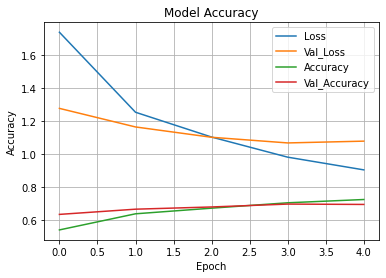

In [ ]:
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Val_Loss')
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val_Accuracy')
plt.legend()
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

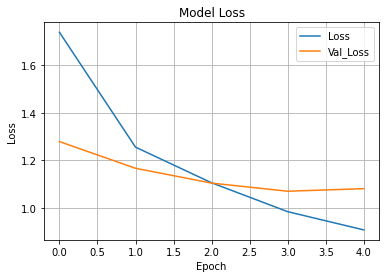

In [ ]:
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Val_Loss')
plt.title('Model Loss')
plt.legend()
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

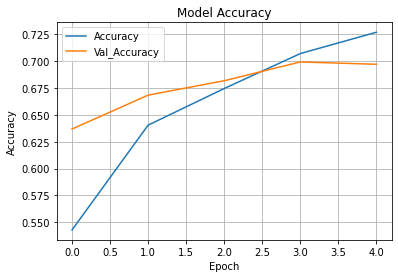

In [ ]:
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val_Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [ ]:
scores = model.evaluate_generator(val_generator, steps=5)

In [ ]:
print("-- Evaluate --")
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
accuracy: 71.25%
